In [1]:

import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from pathlib import Path

# this makes all plots look nicer, and high dpi
# sn.set_theme(style="whitegrid", font_scale=1.0, rc={"figure.dpi": 200})
# set a nicer font
# plt.rcParams["font.family"] = "serif"
# To set some sane defaults
matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-dark-palette")
matplotlib.rcParams["font.family"] = "monospace"
matplotlib.rcParams["figure.dpi"] = 200
plt.rcParams["savefig.facecolor"] = "white"
# sn.set_context("talk")
methods = ["fusion", "vertical"]

def parse_file(file):
    """
    The data we want to parse has this format:

    # achieved tok/s: (1028.225806). Tokens: (255), seconds: (0.248)
    # dim: 288
    # hidden_dim: 768
    # n_layers: 6
    # n_heads: 6
    # n_kv_heads 6
    # vocab_size 32000
    # seq_length: 256
    """
    with open(file, "r") as f:
        lines = [line.strip() for line in f.readlines()]

    data = {"dim":[], "fusion":[], "vertical":[]}
    pattern = "dim: \((.*?)\). time1: \((.*?)\), time2: \((.*?)\)"

    for line in lines:
        if r:= re.match(pattern, line):
            dim = int(r.group(1))
            fusion_time = float(r.group(2))*1000
            vertical_time = float(r.group(3))*1000
            data["dim"].append(dim)
            data["fusion"].append(fusion_time)
            data["vertical"].append(vertical_time)
    return data

def plot(df: pd.DataFrame):
    """
    The dataframe has 3 columns: kernel, size, mflops

    We want to plot the mflops for each kernel, for each size as a single seaborn multi-line plot.
    """
    save_dir = Path.cwd()

    plt.figure(figsize=(18, 10))
    colors = sn.color_palette("husl", len(df["method"].unique()))
    sn.lineplot(data=df, x="dim", y="time", hue="method", palette=colors)
    # also plot points, but without legend
    sn.scatterplot(data=df, x="dim", y="time", hue="method", palette=colors, legend=False)

    plt.title("Performance of different MHA kernels")
    plt.xlabel("Dimension of state vector")
    plt.ylabel("Time for one pass of MHA (ms)")
    plt.tight_layout()

    plt.savefig(save_dir / "fusion_benchmark_results.png")


In [2]:
results_dir = Path("benchmark_results/mha")
assert results_dir.is_dir()
data = []
for filename in results_dir.glob("*.txt"):
    # filenames have the format: <kernel_nr>_output.txt
    print(filename)
    results_dict = parse_file(filename)
   
    print(results_dict)
    for method in methods:
        for time, dim in zip(results_dict[method], results_dict["dim"]):
            data.append({"method": method, "dim": dim, "time": time})
df = pd.DataFrame(data)
df

benchmark_results\mha\output.txt
{'dim': [288, 1024, 512], 'fusion': [1.5399999999999998, 4.0, 3.0], 'vertical': [1.3, 3.8, 2.5]}


,method,dim,time
0,fusion,288,1.54
1,fusion,1024,4.00
2,fusion,512,3.00
3,vertical,288,1.30
4,vertical,1024,3.80
5,vertical,512,2.50


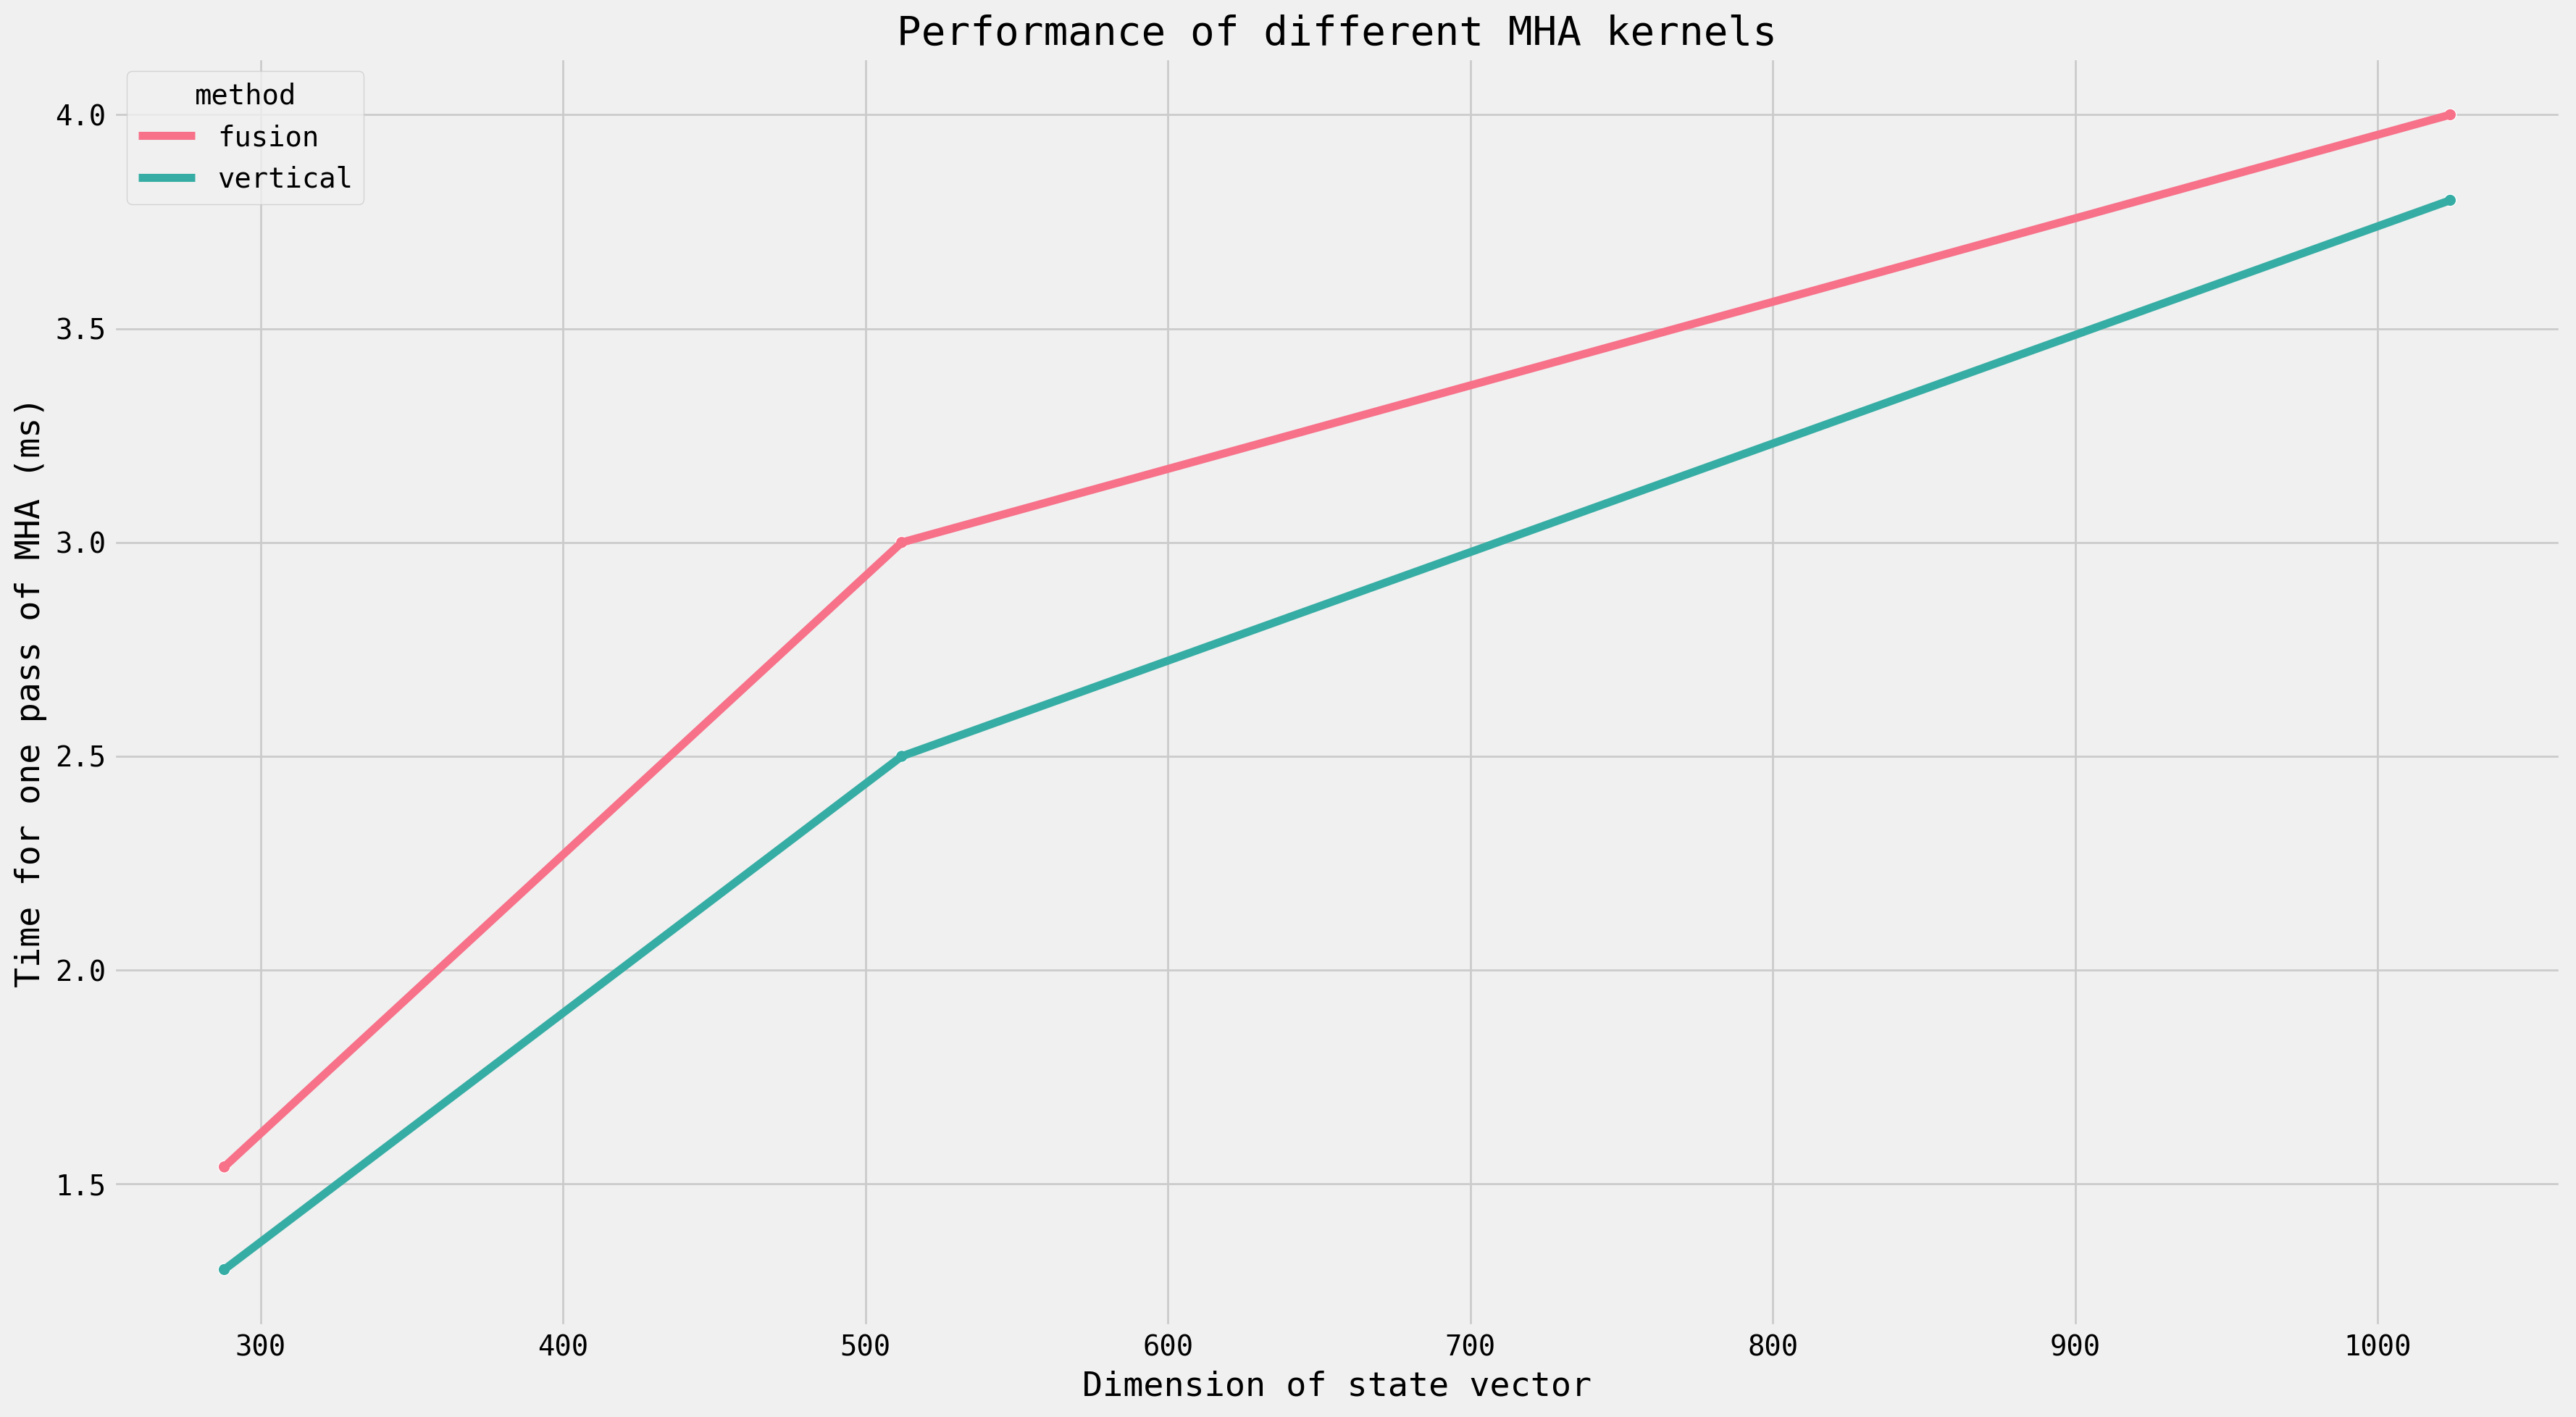

In [24]:
plot(df)

In [3]:
# update the README.md with the new results
with open("README.md", "r") as f:
    readme = f.read()
# delete old results
readme = re.sub(
    r"<!-- fusion_benchmark_results -->.*<!-- fusion_benchmark_results -->",
    "<!-- fusion_benchmark_results -->\n{}\n<!-- fusion_benchmark_results -->".format(
        df.to_markdown(index=False)
    ),
    readme,
    flags=re.DOTALL,
)
# input new results
with open("README.md", "w") as f:
    f.write(readme)
